In [1]:
import pandas as pd
import numpy as np
import os

data_dir = './Data'

pd.set_option('display.max_rows', 150)

<b>Load data</b>

In [2]:
import geopandas as gpd

In [3]:
data_dir = './Data'
df = pd.read_csv(os.path.join(data_dir,'Trade_GDP_CalSuff.csv')).set_index('ISO3').drop(columns=['Unnamed: 0'])
df = df.rename({'GDP_ssp1_2010':'GDP_2010'},axis=1)
df['2013_Trade_Class'] = df['Trade_2013'].values
df['2001_Trade_Class'] = df['Trade_2001'].values

#0 = importer, 1 = medium 2 = exporter,
for ind in range(len(df)):
    if df['2013_Trade_Class'][ind] < 0.1:
        df['2013_Trade_Class'][ind] = 0
    elif df['2013_Trade_Class'][ind] > 0.8:
        df['2013_Trade_Class'][ind] = 2
    else:
         df['2013_Trade_Class'][ind] = 1
            
for ind in range(len(df)):
    if df['2001_Trade_Class'][ind] < 0.1:
        df['2001_Trade_Class'][ind] = 0
    elif df['2001_Trade_Class'][ind] > 0.8:
        df['2001_Trade_Class'][ind] = 2
    else:
         df['2001_Trade_Class'][ind] = 1

<ipython-input-3-5930a93f9d8a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['2013_Trade_Class'][ind] = 1
<ipython-input-3-5930a93f9d8a>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['2013_Trade_Class'][ind] = 0
<ipython-input-3-5930a93f9d8a>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['2013_Trade_Class'][ind] = 2
<ipython-input-3-5930a93f9d8a>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

# Modelling 2050 Trade Index Based on different years of past trade Index(2013, 2001, 1998)

In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [5]:
df['log_GDP_2010'] = df['GDP_2010'].apply(lambda x:np.log(x))
df = df.dropna()

In [7]:
def randForClass_2001():
    X = df[['Calsuff_2000','log_GDP_2010']]  
    y = df['2001_Trade_Class'] 

    X_train, X_test, y_train, y_test= train_test_split(X, y, test_size = 0.2, random_state = 0)
    
    from sklearn.ensemble import RandomForestClassifier

    classifier = RandomForestClassifier()
    classifier.fit(X_train, y_train)
    accuracy = classifier.score(X_test, y_test)
    print("Accuracy = ", accuracy)
    for i in np.arange(1,6):
        df['log_GDP_ssp'+str(i)] = df['GDP_ssp'+str(i)].apply(lambda x:np.log(x))
        
    for i in np.arange(1,6):
        df['Trade_lm_predicted_ssp'+str(i)] = classifier.predict(df[['Calsuff_ssp'+str(i),'log_GDP_ssp'+str(i)]])
        
    df['Repredicted_2001'] = classifier.predict(df[['Calsuff_2000','log_GDP_2010']])
    
    from datetime import datetime

    # datetime object containing current date and time
    now = datetime.now()
    
    dt_string = now.strftime("%d.%m.%Y %H:%M:%S")
    file_name = 'TI_Table_'+dt_string+'.csv'
    df.to_csv(file_name)
        
    import geopandas
    import matplotlib.pyplot as plt
    import matplotlib.colors
    import matplotlib.patches as mpatches
    
    
    #import geoplot

    world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
    world = world.set_index("iso_a3").merge(df)
    
    # Colormap
    colorsList = ['#815abb', '#c4c4c4', '#3b61e9']
    im = mpatches.Patch(color='#815abb', label='Importer')
    med = mpatches.Patch(color='#c4c4c4', label='Medium')
    ex = mpatches.Patch(color='#3b61e9', label='Exporter')
    
    cmap = matplotlib.colors.ListedColormap(colorsList)
    fig, axes = plt.subplots(nrows=4,ncols=2, figsize=(20, 10))
    plt.subplots_adjust(left=0.4, bottom=0.2, right=0.99, top=1.15)

    world.plot(column='Trade_lm_predicted_ssp1', cmap=cmap, linewidth=0.8, ax=axes[0,0])#, edgecolor=’0.8')
    axes[0,0].legend(handles=[im, med, ex], bbox_to_anchor=(1.19, 0.8))

    axes[0,0].set_title('Approximated trade status in 2050 (SSP1)', fontdict={'fontsize':'16'});
    axes[0,0].axis('off');

    world.plot(column='Trade_lm_predicted_ssp2', cmap=cmap, linewidth=0.8, ax=axes[1,0])#, edgecolor=’0.8')
    axes[1,0].set_title('Approximated trade status in 2050 (SSP2)', fontdict={'fontsize':'16'});
    axes[1,0].axis('off');

    world.plot(column='Trade_lm_predicted_ssp3', cmap=cmap,  linewidth=0.8, ax=axes[2,0])#, edgecolor=’0.8')
    axes[2,0].set_title('Approximated trade status in 2050 (SSP3)', fontdict={'fontsize':'16'});
    axes[2,0].axis('off');


    world.plot(column='Trade_lm_predicted_ssp4', cmap=cmap, linewidth=0.8, ax=axes[0,1])#, edgecolor=’0.8')
    axes[0,1].set_title('Approximated trade status in 2050 (SSP4)', fontdict={'fontsize':'16'});
    axes[0,1].axis('off');

    world.plot(column='Trade_lm_predicted_ssp5', cmap=cmap,  linewidth=0.8, ax=axes[1,1])#, edgecolor=’0.8')
    axes[1,1].set_title('Approximated trade status in 2050 (SSP5)', fontdict={'fontsize':'16'});
    axes[1,1].axis('off');

    world.plot(column='2013_Trade_Class', cmap=cmap, linewidth=0.8, ax=axes[2,1])#, edgecolor=’0.8')
    axes[2,1].set_title('Trade independency in 2013 (Kummu, 2020)', fontdict={'fontsize':'16'});
    axes[2,1].axis('off');
    
    world.plot(column='Repredicted_2001', cmap=cmap, linewidth=0.8, ax=axes[3,0])#, edgecolor=’0.8')
    axes[3,0].set_title('Trade independency in 2001 (Repredicted By Model)', fontdict={'fontsize':'16'});
    axes[3,0].axis('off');
    
    world.plot(column='2001_Trade_Class', cmap=cmap, linewidth=0.8, ax=axes[3,1])#, edgecolor=’0.8')
    axes[3,1].set_title('Trade independency in 2001 (Original)', fontdict={'fontsize':'16'});
    axes[3,1].axis('off');
    
   

    # dd/mm/YY H:M:S
    dt_string = now.strftime("%d.%m.%Y %H:%M:%S")
    file_name = 'Maps_TI_'+dt_string+'.png'
    fig.savefig(file_name, bbox_inches='tight')

# Random Forest Tests

## Compare 2050 Predictions(trained on 2001 trade index) with 2013 Trade Index

Accuracy =  0.6896551724137931


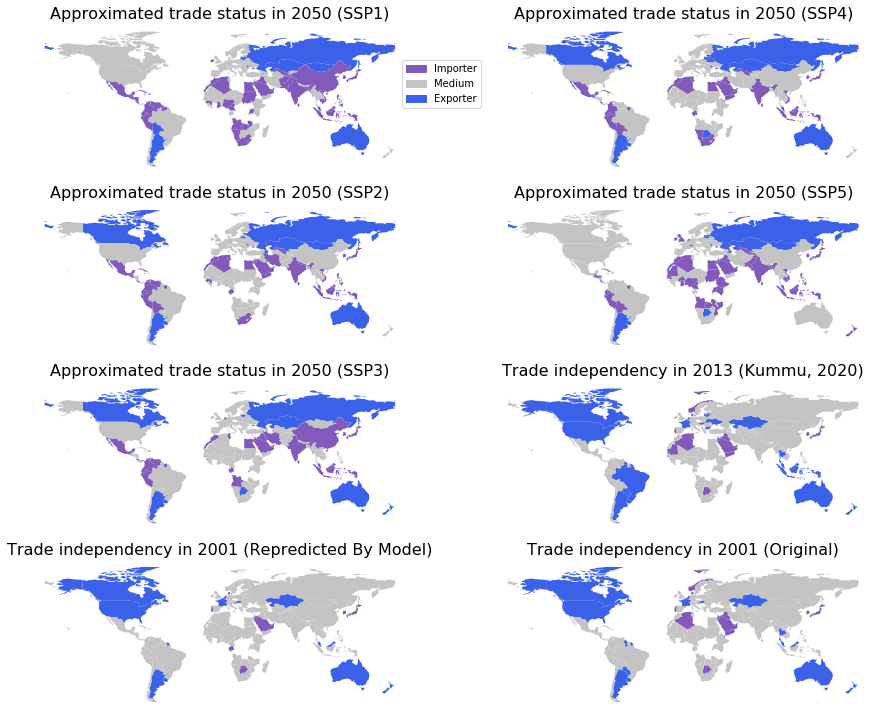

In [8]:
randForClass_2001()

In [9]:
df

Calsuff_2000  Calsuff_ssp1  Calsuff_ssp2  Calsuff_ssp3  Calsuff_ssp4  \
ISO3                                                                         
AFG       0.785233      0.357539      0.302060      0.285515      0.265726   
AGO       0.597733      0.308747      0.397758      0.200725      0.310365   
ALB       2.319537      2.144321      2.112085      1.997762      2.156844   
ARE       0.403014      0.158618      0.152754      0.143927      0.179645   
ARG       8.343864      5.579006      6.409942      6.254420      5.945893   
ARM       1.734574      1.798140      1.967693      1.696076      1.924673   
AUS      11.085546      5.154391      5.066072      8.800898      6.656228   
AUT       2.824697      2.560388      2.677088      2.420327      2.609182   
AZE       2.154729      1.735103      1.762769      1.698961      1.728537   
BEL       1.760203      1.718128      1.811488      1.667407      1.770964   
BEN       1.272741      0.632320      0.596256      0.339371      0.573723   
BFA       3.244740      1.251807      1.219040      0.640384      0.582220   
BGD       0.426684      0.263720      0.301914      0.199636      0.284165   
BGR       3.926297      4.128695      4.237956      3.943891      4.196502   
BIH       2.544224      2.267455      2.459794      2.298638      2.234815   
BLR       4.382329      4.736828      4.798003      4.391782      4.882602   
BLZ       3.276204      2.205947      2.126298      1.215885      1.781585   
BOL       1.983685      1.398107      1.239056      1.289859      1.091153   
BRA       3.919257      3.380699      3.295483      3.378765      2.947675   
BRN       0.642152      0.395898      0.353431      0.692272      0.682248   
BWA       1.002470      4.160516      2.574531     15.824130      5.077024   
CAF       0.480220      0.397516      0.461978      0.394984      1.543470   
CAN       9.838988      4.629821      6.664350      7.424824      7.910551   
CHE       1.402335      1.392875      1.464770      1.365143      1.530688   
CHL       2.425395      1.741742      1.845614      2.119902      2.020523   
CHN       1.640108      1.178607      1.315316      1.248472      1.297196   
CMR       0.739733      0.436841      0.490864      0.471247      0.511140   
COG       1.114826      0.863007      0.870962      0.983864      1.389692   
COL       1.487390      1.021164      1.090994      0.742616      1.233377   
CRI       1.676189      0.798710      0.801878      0.936466      0.836604   
CUB       1.355863      1.145486      1.305167      1.336261      1.367444   
CYP       1.429181      0.971595      1.255055      1.263148      1.234032   
CZE       3.162495      2.488343      2.656615      2.367098      2.607143   
DEU       2.776174      2.237717      2.377024      2.257163      2.315383   
DJI       0.128998      0.198641      0.242289      0.259307      0.136965   
DNK       6.923154      4.635681      4.592175      4.335924      4.776434   
DOM       0.837167      0.519196      0.705039      0.387721      0.676520   
DZA       0.530317      0.987536      0.841282      0.487294      0.784222   
ECU       0.923171      0.793229      0.869977      0.593963      0.856009   
EGY       0.684582      0.364707      0.255898      0.436216      0.331568   
ESP       3.400046      2.924020      3.027331      2.927911      2.994717   
EST       3.227167      4.511578      4.955776      4.147487      5.585818   
ETH       1.054888      0.423090      0.474440      0.621935      0.539537   
FIN       2.696490      4.005251      4.237921      3.595807      4.253563   
FRA       5.985336      3.589867      3.619719      3.615303      3.599533   
GAB       0.698026      2.222532      0.663236      0.633798      1.329227   
GBR       1.891066      1.470789      1.502612      1.377058      1.570558   
GEO       1.660070      3.390163      2.437228      2.037862      3.111825   
GHA       1.072453      0.473488      0.520046      0.414151      0.486281   
GIN       1.347452      1.06

In [10]:
temp = df[['2001_Trade_Class','Repredicted_2001', 'name']]
errors = []

for ind in range(len(temp)):
    if temp['2001_Trade_Class'][ind] != temp['Repredicted_2001'][ind]:
        errors.append(temp['name'][ind])
        
print(len(errors), "countries were incorrectly predicted by the model on the 2001 data(which it was trained on)", errors);
print()

temp = df[['Trade_lm_predicted_ssp1', 'Trade_lm_predicted_ssp2', 'Trade_lm_predicted_ssp3','Trade_lm_predicted_ssp4','Trade_lm_predicted_ssp5','Trade_2013','GDP_ssp1','GDP_ssp2','GDP_ssp3','GDP_ssp4','GDP_ssp5','name']]
predicted_2013= temp.copy()

## Importer-Exporter Analysis

9 countries were incorrectly predicted by the model on the 2001 data(which it was trained on) ['Belize', 'Algeria', 'Gabon', 'Guyana', 'Iraq', 'Norway', 'Paraguay', 'Thailand', 'Yemen']



### Within the countries exporters in 2013, how many remain exporters in 2050?

In [11]:
#xx remain exporters under all scenarios
remain_exp = []
for ind in range(len(df)):
    if predicted_2013['Trade_lm_predicted_ssp1'][ind] == 2 and predicted_2013['Trade_lm_predicted_ssp2'][ind] == 2 and predicted_2013['Trade_lm_predicted_ssp3'][ind] == 2 and predicted_2013['Trade_lm_predicted_ssp4'][ind] == 2 and predicted_2013['Trade_lm_predicted_ssp5'][ind] == 2 and df['2013_Trade_Class'][ind] == 2:
        remain_exp.append(predicted_2013['name'][ind])
print(len(remain_exp), " countries remain exporters from 2013 to 2050 in all SSPs", remain_exp);
print()

#xx remain exporters only in some scenarios
remain_exp1 = []
for ind in range(len(df)):
    if predicted_2013['Trade_lm_predicted_ssp1'][ind] == 2 and df['2013_Trade_Class'][ind] == 2:
        remain_exp1.append(predicted_2013['name'][ind])
print(len(remain_exp1), " countries remain exporters from 2013 to 2050 in SSP1", remain_exp1);
print()

remain_exp2 = []
for ind in range(len(df)):
    if predicted_2013['Trade_lm_predicted_ssp2'][ind] == 2 and df['2013_Trade_Class'][ind] == 2:
        remain_exp2.append(predicted_2013['name'][ind])
print(len(remain_exp2), " countries remain exporters from 2013 to 2050 in SSP2", remain_exp2);
print()

remain_exp3 = []
for ind in range(len(df)):
    if predicted_2013['Trade_lm_predicted_ssp3'][ind] == 2 and df['2013_Trade_Class'][ind] == 2:
        remain_exp3.append(predicted_2013['name'][ind])
print(len(remain_exp3), " countries remain exporters from 2013 to 2050 in SSP3", remain_exp3);
print()

remain_exp4 = []
for ind in range(len(df)):
    if predicted_2013['Trade_lm_predicted_ssp4'][ind] == 2 and df['2013_Trade_Class'][ind] == 2:
        remain_exp4.append(predicted_2013['name'][ind])
print(len(remain_exp4), " countries remain exporters from 2013 to 2050 in SSP4", remain_exp4);
print()

remain_exp5 = []
for ind in range(len(df)):
    if predicted_2013['Trade_lm_predicted_ssp5'][ind] == 2 and df['2013_Trade_Class'][ind] == 2:
        remain_exp5.append(predicted_2013['name'][ind])
print(len(remain_exp5), " countries remain exporters from 2013 to 2050 in SSP5", remain_exp5);
print()

#xx NOT remain exporters under all scenarios
remain_exp = []
for ind in range(len(df)):
    if predicted_2013['Trade_lm_predicted_ssp1'][ind] != 2 and predicted_2013['Trade_lm_predicted_ssp2'][ind] != 2 and predicted_2013['Trade_lm_predicted_ssp3'][ind] != 2 and predicted_2013['Trade_lm_predicted_ssp4'][ind] != 2 and predicted_2013['Trade_lm_predicted_ssp5'][ind] != 2 and df['2013_Trade_Class'][ind] == 2:
        remain_exp.append(predicted_2013['name'][ind])
print(len(remain_exp), " countries do not remain exporters from 2013 to 2050 in all SSPs", remain_exp);
print()

#xx NOT remain exporters only in some scenarios
remain_exp1 = []
for ind in range(len(df)):
    if predicted_2013['Trade_lm_predicted_ssp1'][ind] != 2 and df['2013_Trade_Class'][ind] == 2:
        remain_exp1.append(predicted_2013['name'][ind])
print(len(remain_exp1), " countries do not remain exporters from 2013 to 2050 in SSP1", remain_exp1);
print()

remain_exp2 = []
for ind in range(len(df)):
    if predicted_2013['Trade_lm_predicted_ssp2'][ind] != 2 and df['2013_Trade_Class'][ind] == 2:
        remain_exp2.append(predicted_2013['name'][ind])
print(len(remain_exp2), " countries do not remain exporters from 2013 to 2050 in SSP2", remain_exp2);
print()

remain_exp3 = []
for ind in range(len(df)):
    if predicted_2013['Trade_lm_predicted_ssp3'][ind] != 2 and df['2013_Trade_Class'][ind] == 2:
        remain_exp3.append(predicted_2013['name'][ind])
print(len(remain_exp3), "countries do not remain exporters from 2013 to 2050 in SSP3", remain_exp3);
print()

remain_exp4 = []
for ind in range(len(df)):
    if predicted_2013['Trade_lm_predicted_ssp4'][ind] != 2 and df['2013_Trade_Class'][ind] == 2:
        remain_exp4.append(predicted_2013['name'][ind])
print(len(remain_exp4), "countries remain exporters from 2013 to 2050 in SSP4", remain_exp4);
print()

remain_exp5 = []
for ind in range(len(df)):
    if predicted_2013['Trade_lm_predicted_ssp5'][ind] != 2 and df['2013_Trade_Class'][ind] == 2:
        remain_exp5.append(predicted_2013['name'][ind])
print(len(remain_exp5), "countries do not remain exporters from 2013 to 2050 in SSP5", remain_exp5);
print()

#xx become new exporters
new_exp = []
for ind in range(len(df)):
    if predicted_2013['Trade_lm_predicted_ssp1'][ind] == 2 and predicted_2013['Trade_lm_predicted_ssp2'][ind] == 2 and predicted_2013['Trade_lm_predicted_ssp3'][ind] == 2 and predicted_2013['Trade_lm_predicted_ssp4'][ind] == 2 and predicted_2013['Trade_lm_predicted_ssp5'][ind] == 2 and df['2013_Trade_Class'][ind] != 2:        
        new_exp.append(predicted_2013['name'][ind])
print(len(new_exp), " countries become new exporters from 2013 to 2050 in all SSPs", new_exp);
print()

#xx become exporters only in some scenarios
new_exp1 = []
for ind in range(len(df)):
    if predicted_2013['Trade_lm_predicted_ssp1'][ind] == 2 and df['2013_Trade_Class'][ind] != 2:
        new_exp1.append(predicted_2013['name'][ind])
print(len(new_exp1), " countries become new exporters from 2013 to 2050 in SSP1", new_exp1);
print()

new_exp2 = []
for ind in range(len(df)):
    if predicted_2013['Trade_lm_predicted_ssp2'][ind] == 2 and df['2013_Trade_Class'][ind] != 2:
        new_exp2.append(predicted_2013['name'][ind])
print(len(new_exp2), " countries become new exporters from 2013 to 2050 in SSP2", new_exp2);
print()

new_exp3 = []
for ind in range(len(df)):
    if predicted_2013['Trade_lm_predicted_ssp3'][ind] == 2 and df['2013_Trade_Class'][ind] != 2:
        new_exp3.append(predicted_2013['name'][ind])
print(len(new_exp3), " countries become new exporters from 2013 to 2050 in SSP3", new_exp3);
print()

new_exp4 = []
for ind in range(len(df)):
    if predicted_2013['Trade_lm_predicted_ssp4'][ind] == 2 and df['2013_Trade_Class'][ind] != 2:
        new_exp4.append(predicted_2013['name'][ind])
print(len(new_exp4), " countries become new exporters from 2013 to 2050 in SSP4", new_exp4);
print()

new_exp5 = []
for ind in range(len(df)):
    if predicted_2013['Trade_lm_predicted_ssp5'][ind] == 2 and df['2013_Trade_Class'][ind] != 2:
        new_exp5.append(predicted_2013['name'][ind])
print(len(new_exp5), " countries become new exporters from 2013 to 2050 in SSP5", new_exp5);
print()

3  countries remain exporters from 2013 to 2050 in all SSPs ['Argentina', 'Kazakhstan', 'Lithuania']

5  countries remain exporters from 2013 to 2050 in SSP1 ['Argentina', 'Australia', 'Kazakhstan', 'Lithuania', 'Latvia']

6  countries remain exporters from 2013 to 2050 in SSP2 ['Argentina', 'Australia', 'Canada', 'Kazakhstan', 'Lithuania', 'Uruguay']

7  countries remain exporters from 2013 to 2050 in SSP3 ['Argentina', 'Australia', 'Canada', 'Kazakhstan', 'Lithuania', 'New Zealand', 'Uruguay']

7  countries remain exporters from 2013 to 2050 in SSP4 ['Argentina', 'Australia', 'Canada', 'Kazakhstan', 'Lithuania', 'Latvia', 'Uruguay']

5  countries remain exporters from 2013 to 2050 in SSP5 ['Argentina', 'Kazakhstan', 'Lithuania', 'Latvia', 'Uruguay']

13  countries do not remain exporters from 2013 to 2050 in all SSPs ['Bulgaria', 'Belize', 'Brazil', 'Denmark', 'France', 'Guyana', 'Hungary', 'Indonesia', 'Malaysia', 'Paraguay', 'Thailand', 'Ukraine', 'United States of America']

16  c

### Within the countries importers in 2013, how many remain importers in 2050?

In [12]:
#xx remain importers under all scenarios
remain_imp = []
for ind in range(len(df)):
    if predicted_2013['Trade_lm_predicted_ssp1'][ind] == 0 and predicted_2013['Trade_lm_predicted_ssp2'][ind] == 0 and predicted_2013['Trade_lm_predicted_ssp3'][ind] == 0 and predicted_2013['Trade_lm_predicted_ssp4'][ind] == 0 and predicted_2013['Trade_lm_predicted_ssp5'][ind] == 0 and df['2013_Trade_Class'][ind] == 0:
        remain_imp.append(predicted_2013['name'][ind])
print(len(remain_imp), " countries remain importers from 2013 to 2050 in all SSPs", remain_imp);
print()

#xx remain importers only in some scenarios
remain_imp1 = []
for ind in range(len(df)):
    if predicted_2013['Trade_lm_predicted_ssp1'][ind] == 0 and df['2013_Trade_Class'][ind] == 0:
        remain_imp1.append(predicted_2013['name'][ind])
print(len(remain_imp1), " countries remain importers from 2013 to 2050 in SSP1", remain_imp1);
print()

remain_imp2 = []
for ind in range(len(df)):
    if predicted_2013['Trade_lm_predicted_ssp2'][ind] == 0 and df['2013_Trade_Class'][ind] == 0:
        remain_imp2.append(predicted_2013['name'][ind])
print(len(remain_imp2), " countries remain importers from 2013 to 2050 in SSP2", remain_imp2);
print()

remain_imp3 = []
for ind in range(len(df)):
    if predicted_2013['Trade_lm_predicted_ssp3'][ind] == 0 and df['2013_Trade_Class'][ind] == 0:
        remain_imp3.append(predicted_2013['name'][ind])
print(len(remain_imp3), " countries remain importers from 2013 to 2050 in SSP3", remain_imp3);
print()

remain_imp4 = []
for ind in range(len(df)):
    if predicted_2013['Trade_lm_predicted_ssp4'][ind] == 0 and df['2013_Trade_Class'][ind] == 0:
        remain_imp4.append(predicted_2013['name'][ind])
print(len(remain_imp4), " countries remain importers from 2013 to 2050 in SSP4", remain_imp4);
print()

remain_imp5 = []
for ind in range(len(df)):
    if predicted_2013['Trade_lm_predicted_ssp5'][ind] == 0 and df['2013_Trade_Class'][ind] == 0:
        remain_imp5.append(predicted_2013['name'][ind])
print(len(remain_imp5), " countries remain importers from 2013 to 2050 in SSP5", remain_imp5);
print()

#xx NOT remain importers under all scenarios
remain_imp = []
for ind in range(len(df)):
    if predicted_2013['Trade_lm_predicted_ssp1'][ind] != 0 and predicted_2013['Trade_lm_predicted_ssp2'][ind] != 0 and predicted_2013['Trade_lm_predicted_ssp3'][ind] != 0 and predicted_2013['Trade_lm_predicted_ssp4'][ind] != 0 and predicted_2013['Trade_lm_predicted_ssp5'][ind] != 0 and df['2013_Trade_Class'][ind] == 0:
        remain_imp.append(predicted_2013['name'][ind])
print(len(remain_imp), " countries do not remain importers from 2013 to 2050 in all SSPs", remain_imp);
print()

#xx NOT remain importers only in some scenarios
remain_imp1 = []
for ind in range(len(df)):
    if predicted_2013['Trade_lm_predicted_ssp1'][ind] != 0 and df['2013_Trade_Class'][ind] == 0:
        remain_imp1.append(predicted_2013['name'][ind])
print(len(remain_imp1), " countries do not remain importers from 2013 to 2050 in SSP1", remain_imp1);
print()

remain_imp2 = []
for ind in range(len(df)):
    if predicted_2013['Trade_lm_predicted_ssp2'][ind] != 0 and df['2013_Trade_Class'][ind] == 0:
        remain_imp2.append(predicted_2013['name'][ind])
print(len(remain_imp2), " countries do not remain importers from 2013 to 2050 in SSP2", remain_imp2);
print()

remain_imp3 = []
for ind in range(len(df)):
    if predicted_2013['Trade_lm_predicted_ssp3'][ind] != 0 and df['2013_Trade_Class'][ind] == 0:
        remain_imp3.append(predicted_2013['name'][ind])
print(len(remain_imp3), "countries do not remain importers from 2013 to 2050 in SSP3", remain_imp3);
print()

remain_imp4 = []
for ind in range(len(df)):
    if predicted_2013['Trade_lm_predicted_ssp4'][ind] != 0 and df['2013_Trade_Class'][ind] == 0:
        remain_imp4.append(predicted_2013['name'][ind])
print(len(remain_imp4), "countries remain importers from 2013 to 2050 in SSP4", remain_imp4);
print()

remain_imp5 = []
for ind in range(len(df)):
    if predicted_2013['Trade_lm_predicted_ssp5'][ind] != 0 and df['2013_Trade_Class'][ind] == 0:
        remain_imp5.append(predicted_2013['name'][ind])
print(len(remain_imp5), "countries do not remain importers from 2013 to 2050 in SSP5", remain_imp5);
print()

#xx become new importers
new_imp = []
for ind in range(len(df)):
    if predicted_2013['Trade_lm_predicted_ssp1'][ind] == 0 and predicted_2013['Trade_lm_predicted_ssp2'][ind] == 0 and predicted_2013['Trade_lm_predicted_ssp3'][ind] == 0 and predicted_2013['Trade_lm_predicted_ssp4'][ind] == 0 and predicted_2013['Trade_lm_predicted_ssp5'][ind] == 0 and df['2013_Trade_Class'][ind] != 0:        
        new_imp.append(predicted_2013['name'][ind])
print(len(new_imp), " countries become new importers from 2013 to 2050 in all SSPs", new_imp);
print()

#xx become importers only in some scenarios
new_imp1 = []
for ind in range(len(df)):
    if predicted_2013['Trade_lm_predicted_ssp1'][ind] == 0 and df['2013_Trade_Class'][ind] != 0:
        new_imp1.append(predicted_2013['name'][ind])
print(len(new_imp1), " countries become new importers from 2013 to 2050 in SSP1", new_imp1);
print()

new_imp2 = []
for ind in range(len(df)):
    if predicted_2013['Trade_lm_predicted_ssp2'][ind] == 0 and df['2013_Trade_Class'][ind] != 0:
        new_imp2.append(predicted_2013['name'][ind])
print(len(new_imp2), " countries become new importers from 2013 to 2050 in SSP2", new_imp2);
print()

new_imp3 = []
for ind in range(len(df)):
    if predicted_2013['Trade_lm_predicted_ssp3'][ind] == 0 and df['2013_Trade_Class'][ind] != 0:
        new_imp3.append(predicted_2013['name'][ind])
print(len(new_imp3), " countries become new importers from 2013 to 2050 in SSP3", new_imp3);
print()

new_imp4 = []
for ind in range(len(df)):
    if predicted_2013['Trade_lm_predicted_ssp4'][ind] == 0 and df['2013_Trade_Class'][ind] != 0:
        new_imp4.append(predicted_2013['name'][ind])
print(len(new_imp4), " countries become new importers from 2013 to 2050 in SSP4", new_imp4);
print()

new_imp5 = []
for ind in range(len(df)):
    if predicted_2013['Trade_lm_predicted_ssp5'][ind] == 0 and df['2013_Trade_Class'][ind] != 0:
        new_imp5.append(predicted_2013['name'][ind])
print(len(new_imp5), " countries become new importers from 2013 to 2050 in SSP5", new_imp5);
print()



11  countries remain importers from 2013 to 2050 in all SSPs ['United Arab Emirates', 'Brunei', 'Djibouti', 'Israel', 'Jordan', 'Japan', 'South Korea', 'Kuwait', 'Lebanon', 'Saudi Arabia', 'Trinidad and Tobago']

15  countries remain importers from 2013 to 2050 in SSP1 ['United Arab Emirates', 'Brunei', 'Cyprus', 'Djibouti', 'Algeria', 'Gambia', 'Iraq', 'Israel', 'Jordan', 'Japan', 'South Korea', 'Kuwait', 'Lebanon', 'Saudi Arabia', 'Trinidad and Tobago']

15  countries remain importers from 2013 to 2050 in SSP2 ['United Arab Emirates', 'Brunei', 'Djibouti', 'Algeria', 'Israel', 'Jordan', 'Japan', 'South Korea', 'Kuwait', 'Lebanon', 'Montenegro', 'Saudi Arabia', 'Trinidad and Tobago', 'Tunisia', 'Yemen']

16  countries remain importers from 2013 to 2050 in SSP3 ['United Arab Emirates', 'Brunei', 'Cyprus', 'Djibouti', 'Gambia', 'Iraq', 'Israel', 'Jordan', 'Japan', 'South Korea', 'Kuwait', 'Lebanon', 'Netherlands', 'Saudi Arabia', 'Trinidad and Tobago', 'Tunisia']

16  countries remain i

# Linear Regression Tests

In [14]:
def lin_reg(trade_out, comp_map_name):
    X = df[['Calsuff_2000','log_GDP_2010']]  
    y = df[trade_out] 

    X_train, X_test, y_train, y_test= train_test_split(X, y, test_size = 0.2, random_state = 0)
    
    regressor = LinearRegression()  
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)
    from sklearn.metrics import mean_squared_error
    from math import sqrt

    rms = sqrt(mean_squared_error(y_test, y_pred))
    print("RMS(Root Mean Squared Error) = ", rms)
    
    for i in np.arange(1,6):
        df['log_GDP_ssp'+str(i)] = df['GDP_ssp'+str(i)].apply(lambda x:np.log(x))
        
    for i in np.arange(1,6):
        df['Trade_lm_predicted_ssp'+str(i)] = regressor.predict(df[['Calsuff_ssp'+str(i),'log_GDP_ssp'+str(i)]])
        
    import geopandas
    import matplotlib.pyplot as plt
    import matplotlib.colors
    #import geoplot

    world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
    world = world.set_index("iso_a3").merge(df)
    
    # Colormap
    levels = [0, 0.2, 0.4, 0.6, 0.8, 0.99,1.01]
    colors = ['#dadaeb', '#9e9ac8', '#756bb1', '#54278f','#3f007d','black']
    cmap, norm = matplotlib.colors.from_levels_and_colors(levels, colors)

    fig, axes = plt.subplots(nrows=3,ncols=2, figsize=(20, 10))

    world.plot(column='Trade_lm_predicted_ssp1', cmap=cmap, norm=norm, linewidth=0.8, ax=axes[0,0])#, edgecolor=’0.8')
    axes[0,0].set_title('Approximated trade Indep SSP1 2050', fontdict={'fontsize':'16'});
    axes[0,0].axis('off');

    world.plot(column='Trade_lm_predicted_ssp2', cmap=cmap, norm=norm,  linewidth=0.8, ax=axes[1,0])#, edgecolor=’0.8')
    axes[1,0].set_title('Approximated trade Indep SSP2 2050', fontdict={'fontsize':'16'});
    axes[1,0].axis('off');

    world.plot(column='Trade_lm_predicted_ssp3', cmap=cmap, norm=norm,  linewidth=0.8, ax=axes[2,0])#, edgecolor=’0.8')
    axes[2,0].set_title('Approximated trade Indep SSP3 2050', fontdict={'fontsize':'16'});
    axes[2,0].axis('off');


    world.plot(column='Trade_lm_predicted_ssp4', cmap=cmap, norm=norm,  linewidth=0.8, ax=axes[0,1])#, edgecolor=’0.8')
    axes[0,1].set_title('Approximated trade Indep SSP4 2050', fontdict={'fontsize':'16'});
    axes[0,1].axis('off');

    world.plot(column='Trade_lm_predicted_ssp5', cmap=cmap, norm=norm,  linewidth=0.8, ax=axes[1,1])#, edgecolor=’0.8')
    axes[1,1].set_title('Approximated trade Indep SSP5 2050', fontdict={'fontsize':'16'});
    axes[1,1].axis('off');

    world.plot(column=trade_out, cmap=cmap, norm=norm,  linewidth=0.8, ax=axes[2,1])#, edgecolor=’0.8')
    axes[2,1].set_title(comp_map_name, fontdict={'fontsize':'16'});
    axes[2,1].axis('off');

## Compare 2050 Predictions(trained on 2001 trade index) with 2001 Trade Index

RMS(Root Mean Squared Error) =  0.2788803872041398


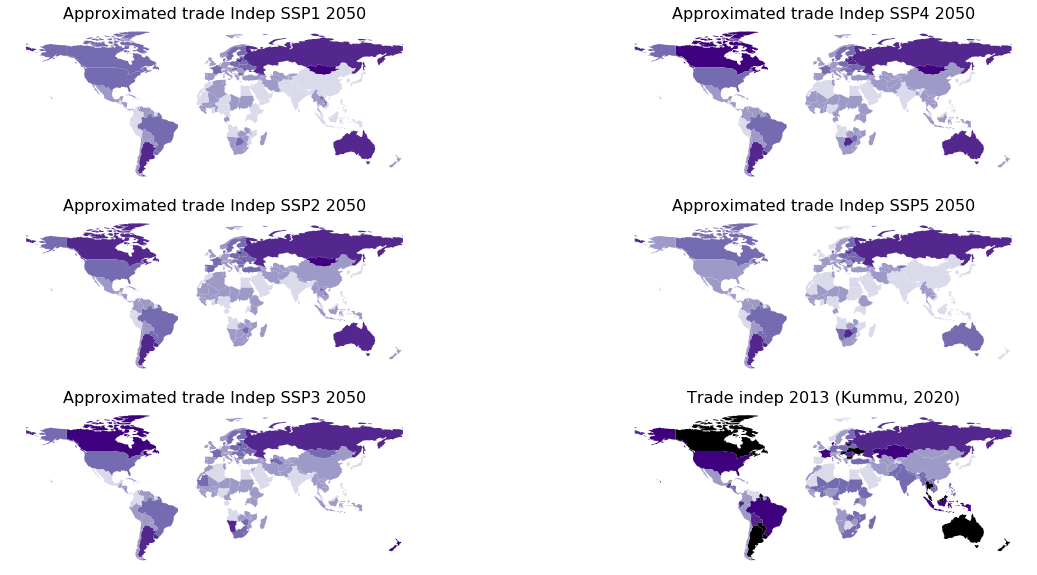

In [15]:
lin_reg('Trade_2013', 'Trade indep 2013 (Kummu, 2020)')

In [16]:
temp = df[['Trade_lm_predicted_ssp1', 'Trade_lm_predicted_ssp2', 'Trade_lm_predicted_ssp3','Trade_lm_predicted_ssp4','Trade_lm_predicted_ssp5','Trade_2013','GDP_ssp1','GDP_ssp2','GDP_ssp3','GDP_ssp4','GDP_ssp5','name']]
predicted_2013= temp.copy()

RMS(Root Mean Squared Error) =  0.23937078948630955


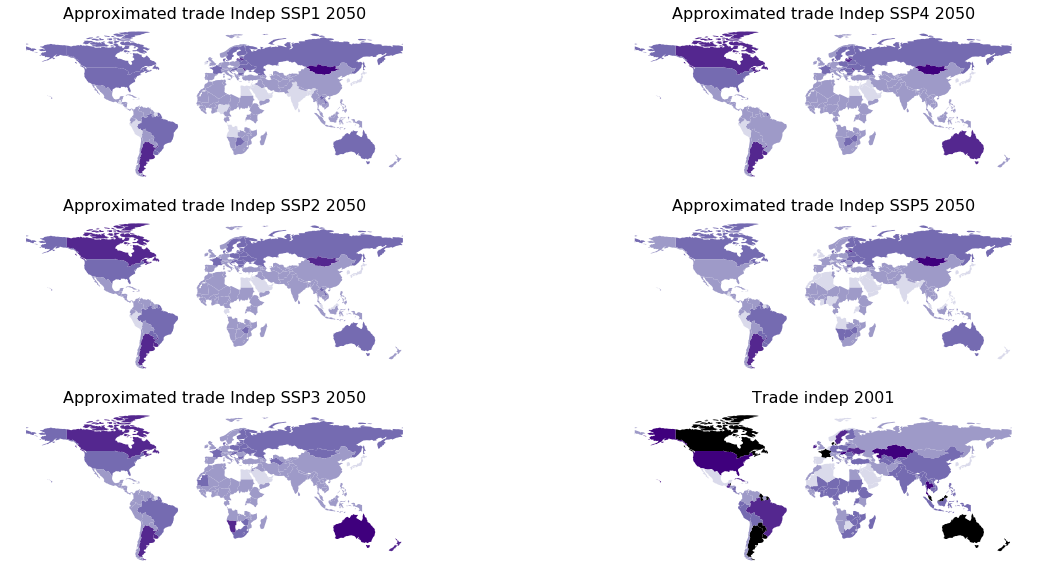

In [17]:
lin_reg('Trade_2001', 'Trade indep 2001')

In [18]:
temp = df[['Trade_lm_predicted_ssp1', 'Trade_lm_predicted_ssp2', 'Trade_lm_predicted_ssp3','Trade_lm_predicted_ssp4','Trade_lm_predicted_ssp5','Trade_2001','GDP_ssp1','GDP_ssp2','GDP_ssp3','GDP_ssp4','GDP_ssp5','name']]
predicted_2001= temp.copy()

## Compare 2050 Predictions(trained on 1998 trade index) with 1998 Trade Index

RMS(Root Mean Squared Error) =  0.2313309140231337


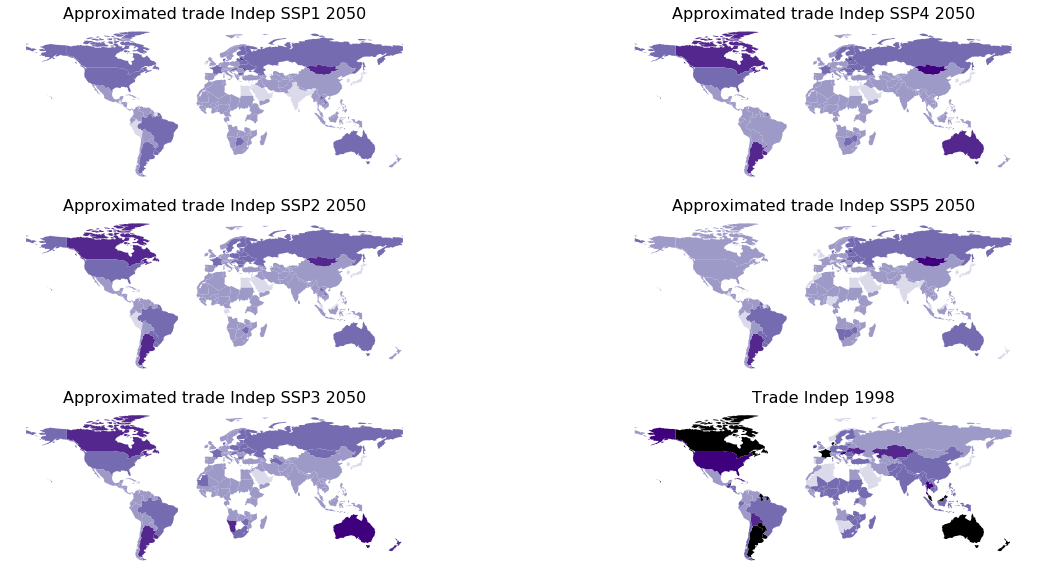

In [19]:
lin_reg('Trade_1998', 'Trade Indep 1998')

In [20]:
temp = df[['Trade_lm_predicted_ssp1', 'Trade_lm_predicted_ssp2', 'Trade_lm_predicted_ssp3','Trade_lm_predicted_ssp4','Trade_lm_predicted_ssp5','Trade_1998','GDP_ssp1','GDP_ssp2','GDP_ssp3','GDP_ssp4','GDP_ssp5','name']]
predicted_1998= temp.copy()

# Comparing the Predictions Made Based on Different Years

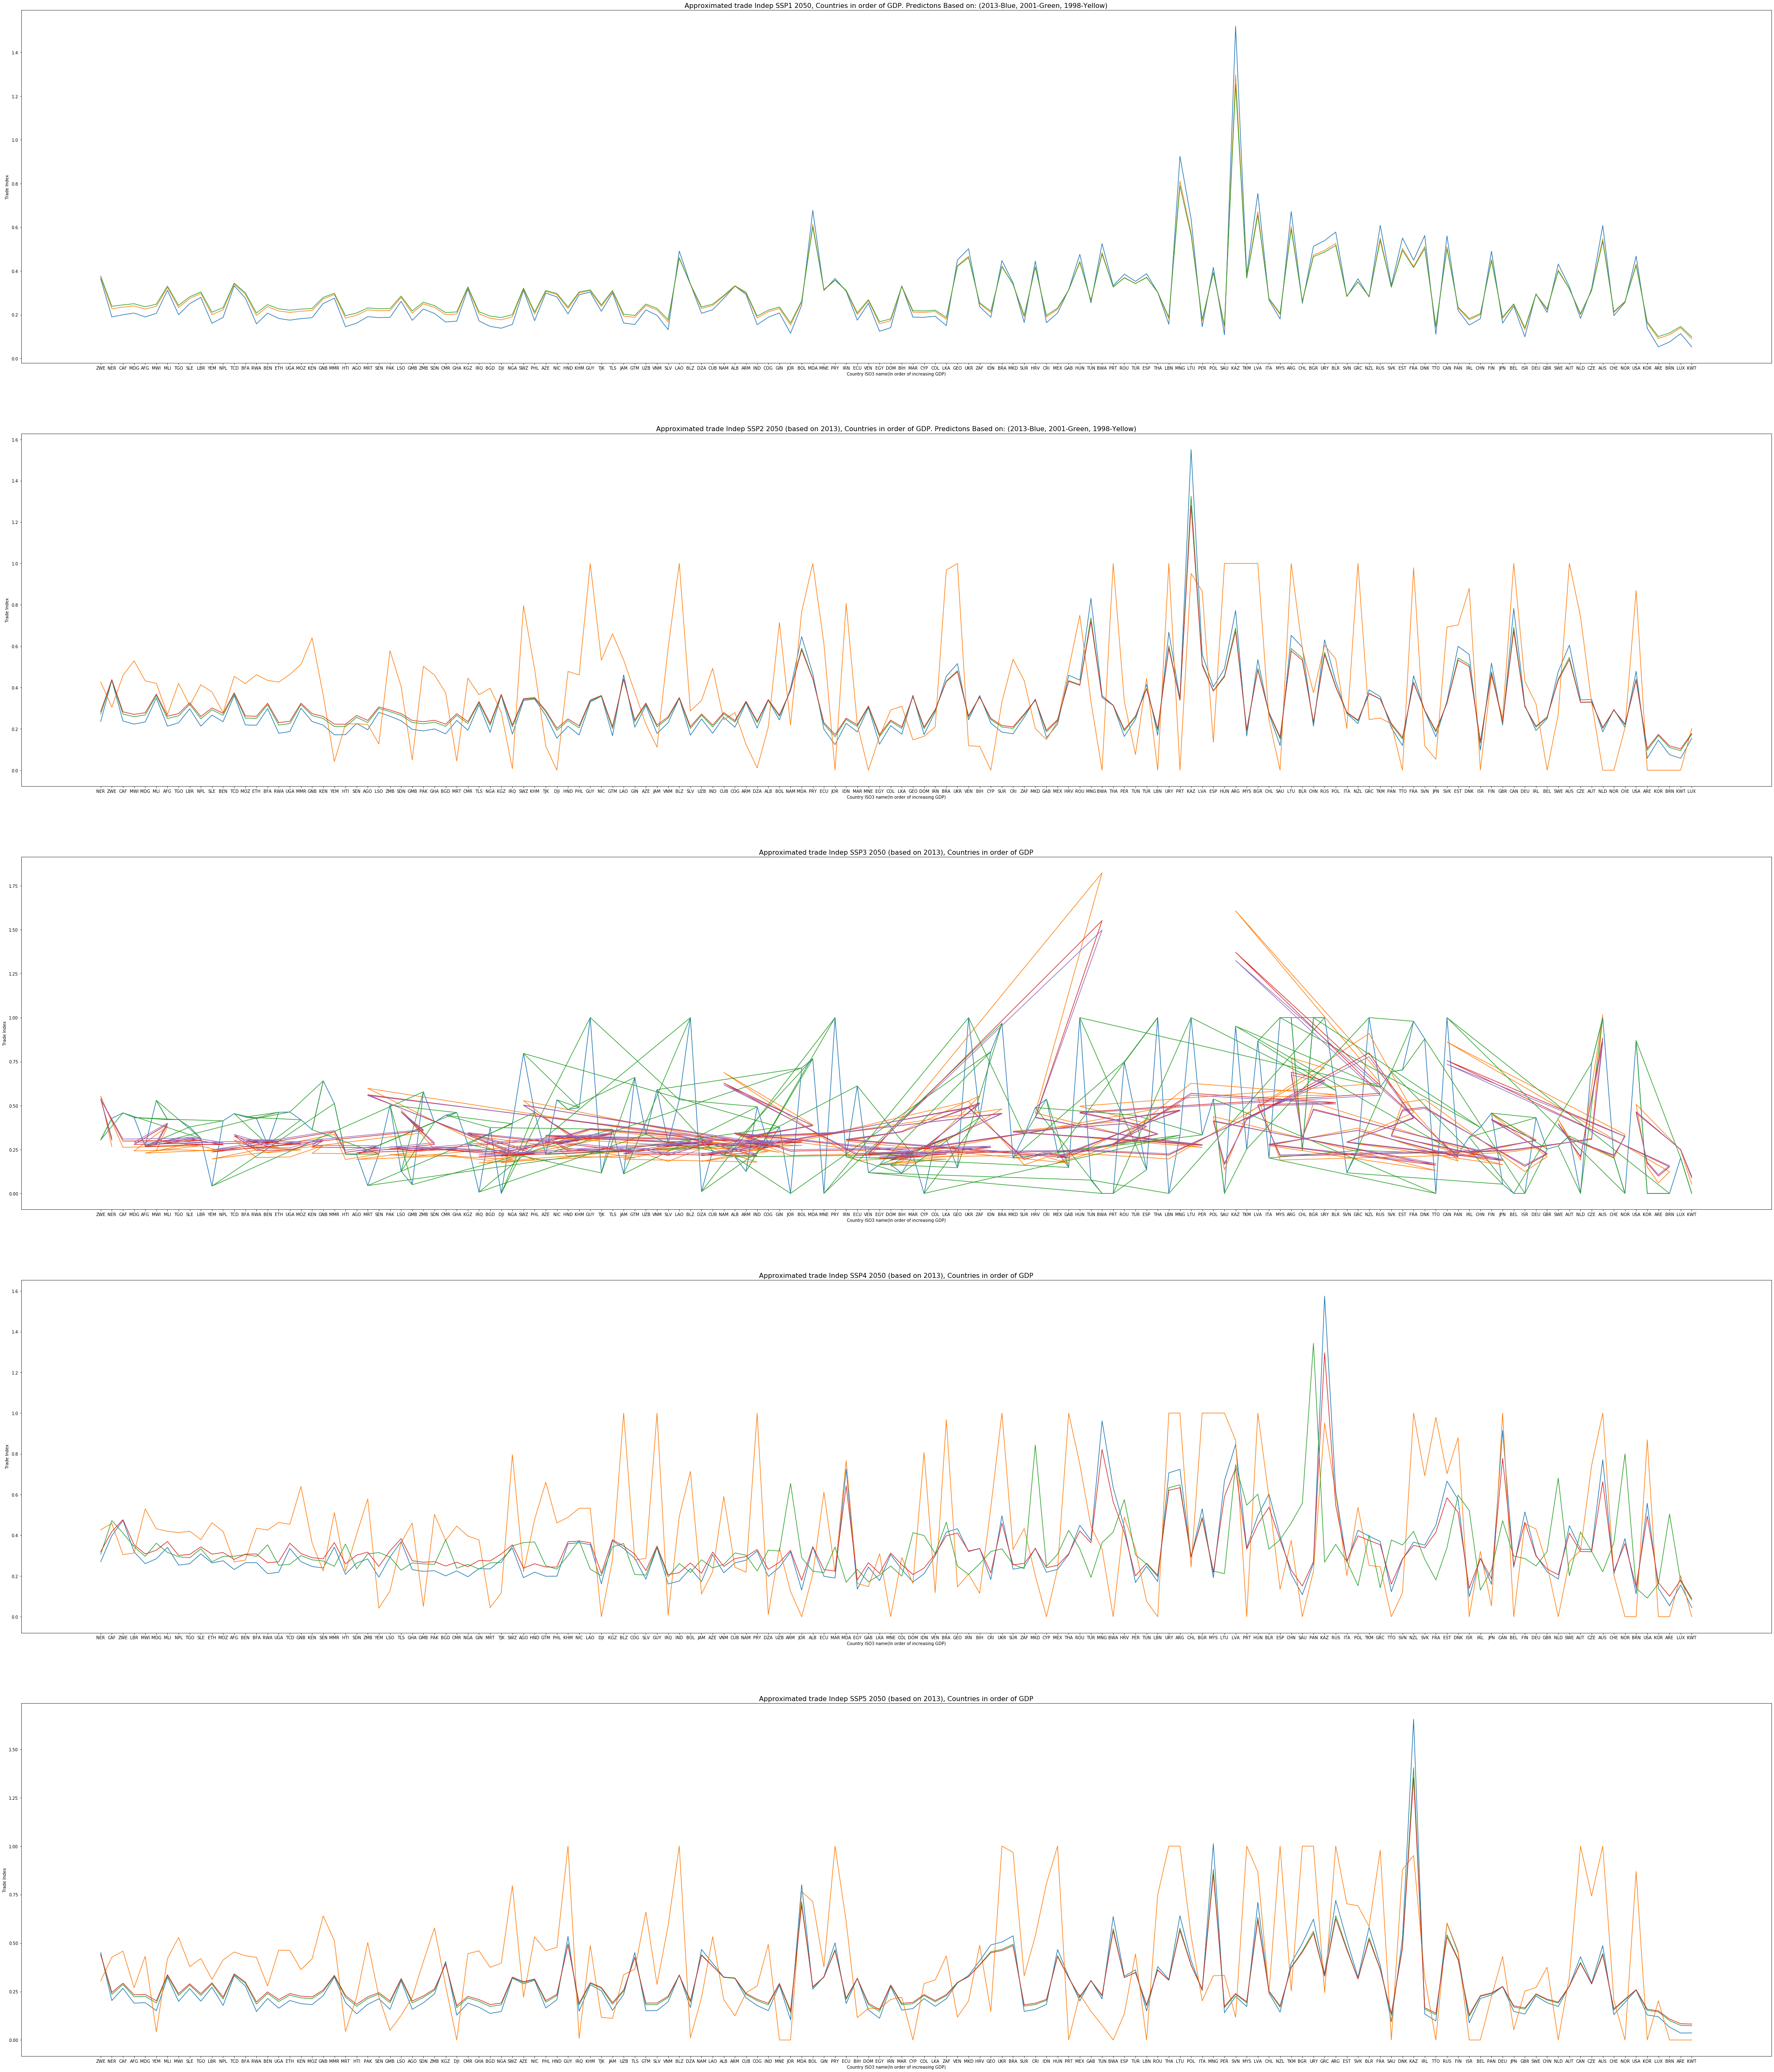

In [21]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

labelencoder = LabelEncoder()
fig, axes = plt.subplots(5, 1,  figsize=(75, 90)) 
#SSP 1
axes[0].set_title('Approximated trade Indep SSP1 2050, Countries in order of GDP. Predictons Based on: (2013-Blue, 2001-Green, 1998-Yellow)', fontdict={'fontsize':'16'});
predicted_2013_GDP_1= predicted_2013.sort_values(by=['GDP_ssp1'])
predicted_2013_GDP_1['name_ind']= predicted_2013_GDP_1.index
axes[0].plot(predicted_2013_GDP_1['name_ind'], predicted_2013_GDP_1['Trade_lm_predicted_ssp1'])
axes[2].plot(predicted_2013_GDP_1['name_ind'], predicted_2013_GDP_1['Trade_2013'])


predicted_2001_GDP_1= predicted_2001.sort_values(by=['GDP_ssp1'])
predicted_2001_GDP_1['name_ind']= predicted_2001_GDP_1.index
axes[0].plot(predicted_2001_GDP_1['name_ind'], predicted_2001_GDP_1['Trade_lm_predicted_ssp1'])

predicted_1998_GDP_1= predicted_1998.sort_values(by=['GDP_ssp1'])
predicted_1998_GDP_1['name_ind']= predicted_1998_GDP_1.index
axes[0].plot(predicted_1998_GDP_1['name_ind'], predicted_1998_GDP_1['Trade_lm_predicted_ssp1'])

axes[0].set_xlabel("Country ISO3 name(In order of increasing GDP)")
axes[0].set_ylabel("Trade Index")

#SSP 2
axes[1].set_title('Approximated trade Indep SSP2 2050 (based on 2013), Countries in order of GDP. Predictons Based on: (2013-Blue, 2001-Green, 1998-Yellow)', fontdict={'fontsize':'16'});
predicted_2013_GDP_2= predicted_2013.sort_values(by=['GDP_ssp2'])
predicted_2013_GDP_2['name_ind']= predicted_2013_GDP_2.index
axes[1].plot(predicted_2013_GDP_2['name_ind'], predicted_2013_GDP_2['Trade_lm_predicted_ssp2'])
axes[1].plot(predicted_2013_GDP_2['name_ind'], predicted_2013_GDP_2['Trade_2013'])


predicted_2001_GDP_2= predicted_2001.sort_values(by=['GDP_ssp2'])
predicted_2001_GDP_2['name_ind']= predicted_2001_GDP_2.index
axes[1].plot(predicted_2001_GDP_2['name_ind'], predicted_2001_GDP_2['Trade_lm_predicted_ssp2'])

predicted_1998_GDP_2= predicted_1998.sort_values(by=['GDP_ssp2'])
predicted_1998_GDP_2['name_ind']= predicted_1998_GDP_2.index
axes[1].plot(predicted_1998_GDP_2['name_ind'], predicted_1998_GDP_2['Trade_lm_predicted_ssp2'])

axes[1].set_xlabel("Country ISO3 name(In order of increasing GDP)")
axes[1].set_ylabel("Trade Index")

#SSP 3
axes[2].set_title('Approximated trade Indep SSP3 2050 (based on 2013), Countries in order of GDP', fontdict={'fontsize':'16'});
predicted_2013_GDP_3= predicted_2013.sort_values(by=['GDP_ssp3'])
predicted_2013_GDP_3['name_ind']= predicted_2013_GDP_3.index
axes[2].plot(predicted_2013_GDP_3['name_ind'], predicted_2013_GDP_3['Trade_lm_predicted_ssp3'])
axes[2].plot(predicted_2013_GDP_3['name_ind'], predicted_2013_GDP_3['Trade_2013'])


predicted_2001_GDP_3= predicted_2001.sort_values(by=['GDP_ssp3'])
predicted_2001_GDP_3['name_ind']= predicted_2001_GDP_3.index
axes[2].plot(predicted_2001_GDP_3['name_ind'], predicted_2001_GDP_3['Trade_lm_predicted_ssp3'])

predicted_1998_GDP_3= predicted_1998.sort_values(by=['GDP_ssp3'])
predicted_1998_GDP_3['name_ind']= predicted_1998_GDP_3.index
axes[2].plot(predicted_1998_GDP_3['name_ind'], predicted_1998_GDP_3['Trade_lm_predicted_ssp3'])

axes[2].set_xlabel("Country ISO3 name(In order of increasing GDP)")
axes[2].set_ylabel("Trade Index")

#SSP 4
axes[3].set_title('Approximated trade Indep SSP4 2050 (based on 2013), Countries in order of GDP', fontdict={'fontsize':'16'});
predicted_2013_GDP_4= predicted_2013.sort_values(by=['GDP_ssp4'])
predicted_2013_GDP_4['name_ind']= predicted_2013_GDP_4.index
axes[3].plot(predicted_2013_GDP_4['name_ind'], predicted_2013_GDP_4['Trade_lm_predicted_ssp4'])
axes[3].plot(predicted_2013_GDP_4['name_ind'], predicted_2013_GDP_4['Trade_2013'])


predicted_2001_GDP_4= predicted_2001.sort_values(by=['GDP_ssp4'])
predicted_2001_GDP_4['name_ind']= predicted_2001_GDP_4.index
axes[3].plot(predicted_2001_GDP_4['name_ind'], predicted_2001_GDP_3['Trade_lm_predicted_ssp4'])

predicted_1998_GDP_4= predicted_1998.sort_values(by=['GDP_ssp4'])
predicted_1998_GDP_4['name_ind']= predicted_1998_GDP_4.index
axes[3].plot(predicted_1998_GDP_4['name_ind'], predicted_1998_GDP_4['Trade_lm_predicted_ssp4'])

axes[3].set_xlabel("Country ISO3 name(In order of increasing GDP)")
axes[3].set_ylabel("Trade Index")

#SSP 5
axes[4].set_title('Approximated trade Indep SSP5 2050 (based on 2013), Countries in order of GDP', fontdict={'fontsize':'16'});
predicted_2013_GDP_5= predicted_2013.sort_values(by=['GDP_ssp5'])
predicted_2013_GDP_5['name_ind']= predicted_2013_GDP_5.index
axes[4].plot(predicted_2013_GDP_5['name_ind'], predicted_2013_GDP_5['Trade_lm_predicted_ssp5'])
axes[4].plot(predicted_2013_GDP_5['name_ind'], predicted_2013_GDP_5['Trade_2013'])


predicted_2001_GDP_5= predicted_2001.sort_values(by=['GDP_ssp5'])
predicted_2001_GDP_5['name_ind']= predicted_2001_GDP_5.index
axes[4].plot(predicted_2001_GDP_5['name_ind'], predicted_2001_GDP_5['Trade_lm_predicted_ssp5'])

predicted_1998_GDP_5= predicted_1998.sort_values(by=['GDP_ssp5'])
predicted_1998_GDP_5['name_ind']= predicted_1998_GDP_5.index
axes[4].plot(predicted_1998_GDP_5['name_ind'], predicted_1998_GDP_5['Trade_lm_predicted_ssp5'])

axes[4].set_xlabel("Country ISO3 name(In order of increasing GDP)")
axes[4].set_ylabel("Trade Index")
plt.show()

# Grayscale Sample of Map

In [22]:
import geopandas
import matplotlib.pyplot as plt
import matplotlib.colors
#import geoplot

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world = world.set_index("iso_a3").merge(df)

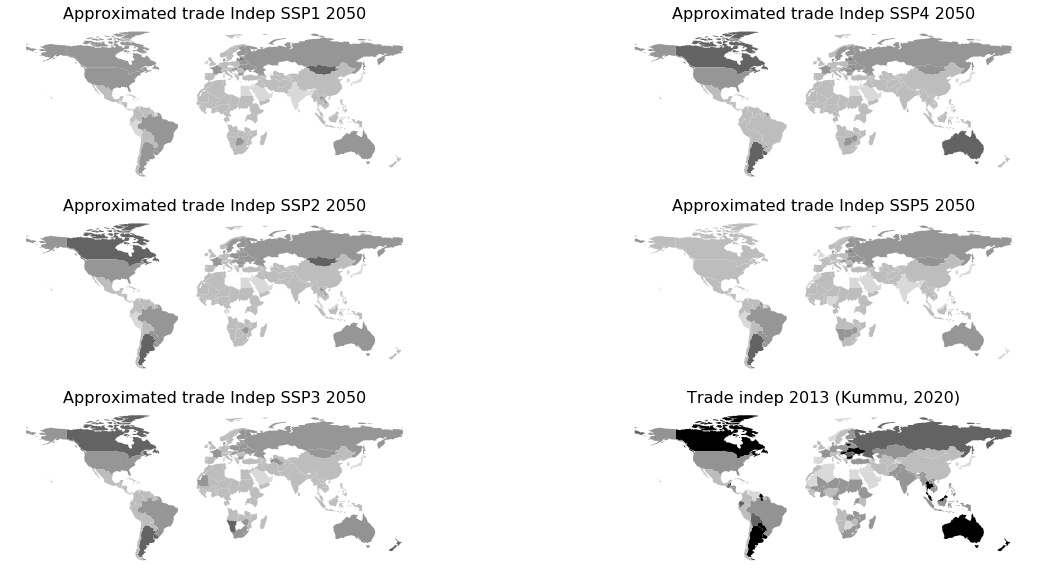

In [23]:
# Colormap
levels = [0, 0.2, 0.4, 0.6, 0.8, 0.99,1.01]
colors = ['#d9d9d9', '#bdbdbd', '#969696','#636363','252525','black']
cmap, norm = matplotlib.colors.from_levels_and_colors(levels, colors)

# Map predicted Trade 2050 and Trade 2013.

fig, axes = plt.subplots(nrows=3,ncols=2, figsize=(20, 10))

world.plot(column='Trade_lm_predicted_ssp1', cmap=cmap, norm=norm,  linewidth=0.8, ax=axes[0,0])#, edgecolor=’0.8')
axes[0,0].set_title('Approximated trade Indep SSP1 2050', fontdict={'fontsize':'16'});
axes[0,0].axis('off');

world.plot(column='Trade_lm_predicted_ssp2', cmap=cmap, norm=norm,  linewidth=0.8, ax=axes[1,0])#, edgecolor=’0.8')
axes[1,0].set_title('Approximated trade Indep SSP2 2050', fontdict={'fontsize':'16'});
axes[1,0].axis('off');

world.plot(column='Trade_lm_predicted_ssp3', cmap=cmap, norm=norm,  linewidth=0.8, ax=axes[2,0])#, edgecolor=’0.8')
axes[2,0].set_title('Approximated trade Indep SSP3 2050', fontdict={'fontsize':'16'});
axes[2,0].axis('off');


world.plot(column='Trade_lm_predicted_ssp4', cmap=cmap, norm=norm,  linewidth=0.8, ax=axes[0,1])#, edgecolor=’0.8')
axes[0,1].set_title('Approximated trade Indep SSP4 2050', fontdict={'fontsize':'16'});
axes[0,1].axis('off');

world.plot(column='Trade_lm_predicted_ssp5', cmap=cmap, norm=norm,  linewidth=0.8, ax=axes[1,1])#, edgecolor=’0.8')
axes[1,1].set_title('Approximated trade Indep SSP5 2050', fontdict={'fontsize':'16'});
axes[1,1].axis('off');

world.plot(column='Trade_2013', cmap=cmap, norm=norm,  linewidth=0.8, ax=axes[2,1])#, edgecolor=’0.8')
axes[2,1].set_title('Trade indep 2013 (Kummu, 2020)', fontdict={'fontsize':'16'});
axes[2,1].axis('off');